# 反応拡散モデル　ギーラー-マインハルト系
$$
\begin{cases}
\frac{\partial u}{\partial t} = D_u \nabla^2 u - d_u u + k_1 \frac{u^2}{v} + k_2\\
\frac{\partial v}{\partial t} = D_v \nabla^2 v - d_v v \ + k_3 u^2 
\end{cases}
$$

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

基本的にやっていることは同じであるが，こちらではブロードキャストを利用しており少し賢い実装になっている．
（こちらのほうが計算がかなり速い）

`laplacian`関数は入力`f`のラプラシアン（$\nabla^2f$）（を近似した配列）を返す関数．

In [145]:
def laplacian(f, dh):
    """ラプラシアン
    
    周期境界条件を仮定している．
    
    Args:
        f:  関数（スカラー場）の配列
        dh: 空間解像度（１セルの幅）
    Returns:
        f_laplacian: fのラプラシアンの配列
    """
    
    f_ext = np.zeros((f.shape[0]+2,f.shape[1]+2),dtype=f.dtype)
    f_ext[1:-1,1:-1] = f[:,:]
    f_ext[0,1:-1] = f[-1,:]
    f_ext[-1,1:-1] = f[0,:]
    f_ext[1:-1,0] = f[:,-1]
    f_ext[1:-1,-1] = f[:,0]
    
    f_c = f_ext[1:-1, 1:-1]
    f_n = f_ext[0:-2, 1:-1]
    f_e = f_ext[1:-1, 2:]
    f_s = f_ext[2:, 1:-1]
    f_w = f_ext[1:-1, 0:-2]
    
    f_laplacian = (f_n + f_e + f_s + f_w - 4 * f_c) / dh**2
    
    return f_laplacian

def update(u, v, D_u, D_v, d_u, d_v, k_1, k_2, k_3, dh, dt):
    """反応拡散モデルに基づくuの更新
    
    場の更新をおこなう．
    周期境界条件を仮定している．
    
    Args:
        u,v:  アクチベーターとインヒビターの現在の場の配列
        D_u, D_v: 拡散係数
        d_u, d_v: 分解率
        k_1: アクチベーターの自己活性化・インヒビターによる抑制
        k_2: アクチベーターの基本的な生成
        k_3: アクチベーターによるインヒビターの生産促進
    Returns:
        u_new, v_new: 次世代の場の配列
    """
    n_i, n_j = u.shape
    new_u = np.zeros((n_i, n_j),dtype=u.dtype)
    new_v = np.zeros((n_i, n_j),dtype=u.dtype)
    
    u_new = u + (D_u*laplacian(u,dh) - d_u*u + k_1*u**2/v + k_2)*dt
    v_new = v + (D_v*laplacian(v,dh) - d_v*v + k_3*u**2)*dt
    
    return (u_new, v_new)

## 別の実装
あるいは[SciPy](https://docs.scipy.org/doc/scipy/reference/index.html)パッケージのラプラシアンフィルタを計算する[`laplace`関数](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.laplace.html)を使っても良い．

速度的には上の実装とそんなに変わらないはず（検証してないので興味ある人は試してみて）．

In [151]:
from scipy import ndimage

In [152]:
def update(u, v, D_u, D_v, d_u, d_v, k_1, k_2, k_3, dh, dt):
    """反応拡散モデルに基づくuの更新
    
    場の更新をおこなう．
    周期境界条件を仮定している．
    
    Args:
        u,v:  アクチベーターとインヒビターの現在の場の配列
        D_u, D_v: 拡散係数
        d_u, d_v: 分解率
        k_1: アクチベーターの自己活性化・インヒビターによる抑制
        k_2: アクチベーターの基本的な生成
        k_3: アクチベーターによるインヒビターの生産促進
    Returns:
        u_new, v_new: 次世代の場の配列
    """
    n_i, n_j = u.shape
    new_u = np.zeros((n_i, n_j),dtype=u.dtype)
    new_v = np.zeros((n_i, n_j),dtype=u.dtype)
    
    u_new = u + (D_u*ndimage.laplace(u,mode="wrap")/dh**2 - d_u*u + k_1*u**2/v + k_2)*dt
    v_new = v + (D_v*ndimage.laplace(v,mode="wrap")/dh**2 - d_v*v + k_3*u**2)*dt
    
    return (u_new, v_new)

In [164]:
D_u = 1.3# 拡散係数 D_uを1~1.5ぐらいで動かす
D_v = 10 # 拡散係数
d_u = 1.0
d_v = 1.0
k_1 = 1.0
k_2 = 0.05
k_3 = 1.0

dt = 0.02 # 時間方向の刻み幅
dh = 1.0 # 空間方向の刻み幅

x = np.arange(-50,50,dh)
y = np.arange(-50,50,dh)
xmesh,ymesh = np.meshgrid(x,y)

T = 3000
nEnd = int(T/dt) # 時間に関するループの繰り返し数
print("繰り返し数: ",nEnd)

tList = [] # 時刻を記録するリスト
uList = [] # uを記録するリスト
vList = [] # vを記録するリスト

# u,vの初期化
u = np.ones([len(x) ,len(y)],dtype = float) 
u = u + np.random.uniform(0,0.01,size=u.shape)
v = np.ones([len(x) ,len(y)],dtype = float) 
v = v + np.random.uniform(0,0.01,size=u.shape)

tList.append(0)
uList.append(np.copy(u))
vList.append(np.copy(v))

for n in range(nEnd):
    t = n*dt # 時刻tの計算
    
    # -- 状態遷移 --
    u_tmp,v_tmp = update(u, v, D_u, D_v, d_u, d_v, k_1, k_2, k_3, dh, dt)
    
    # 情報の更新
    u = np.copy(u_tmp)
    v = np.copy(v_tmp)
    if n%10000 == 0:
        print("Steps: ", n)
    if n%100 == 0:
        tList.append(t)
        uList.append(np.copy(u))
        vList.append(np.copy(v))
print(len(tList))

繰り返し数:  150000
Steps:  0
Steps:  10000
Steps:  20000
Steps:  30000
Steps:  40000
Steps:  50000
Steps:  60000
Steps:  70000
Steps:  80000
Steps:  90000
Steps:  100000
Steps:  110000
Steps:  120000
Steps:  130000
Steps:  140000
1501


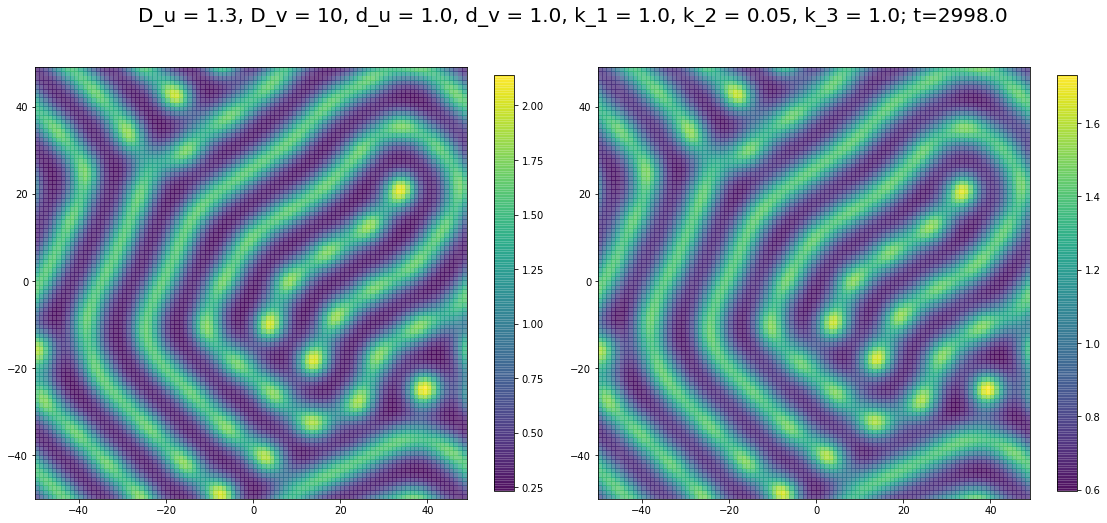

In [165]:
i = -1
fig, ax = plt.subplots(1,2,figsize=(16, 8))

ax[0].set_aspect('equal')
pcm = ax[0].pcolormesh(xmesh,ymesh,uList[i],alpha=0.75)
fig.colorbar(pcm, ax=ax[0], shrink=0.75)

ax[1].set_aspect('equal')
pcm = ax[1].pcolormesh(xmesh,ymesh,vList[i],alpha=0.75)
fig.colorbar(pcm, ax=ax[1], shrink=0.75)

title = ["D_u = " + str(D_u), "D_v = " + str(D_v), "d_u = "+str(d_u), "d_v = "+str(d_v), 
         "k_1 = "+str(k_1),"k_2 = "+str(k_2),"k_3 = "+str(k_3)]
fig.tight_layout()
fig.suptitle(", ".join(title)+"; t="+str(tList[i]),fontsize=20)
plt.show()

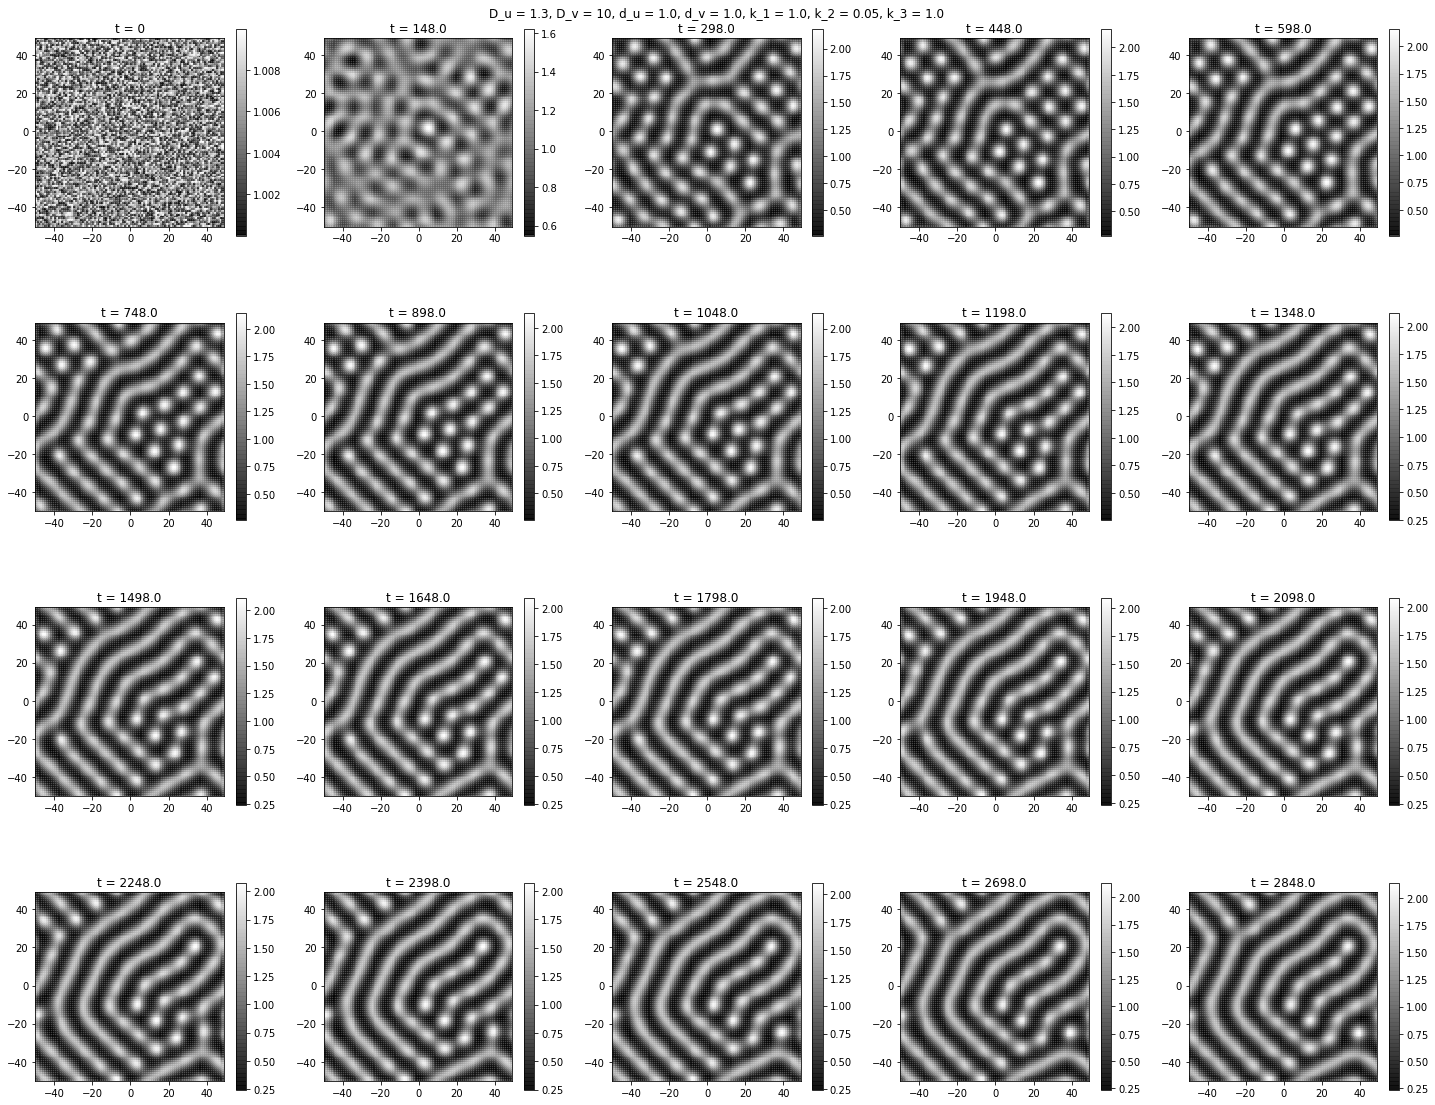

In [166]:
step = 75
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i in [i*step for i in range(20)]:
    ax = axes.flat[i//step]
    ax.set_aspect('equal')
    pcm = ax.pcolormesh(xmesh,ymesh,uList[i],alpha=0.75,cmap="gray")
    
    fig.colorbar(pcm, ax=ax, shrink=0.75)
    ax.set_title("t = " + str(tList[i]))
title = ["D_u = " + str(D_u), "D_v = " + str(D_v), "d_u = "+str(d_u), "d_v = "+str(d_v), 
         "k_1 = "+str(k_1),"k_2 = "+str(k_2),"k_3 = "+str(k_3)]
fig.tight_layout()
fig.suptitle(", ".join(title))
plt.show()